# Printing Data Regression

In [1]:
from methods import RegressionNeograf

import numpy as np
import pandas as pd
import math

Using TensorFlow backend.


In [2]:
# Import Excel documents
df1 = RegressionNeograf.DataFrameImport('dfProduction-debljina.xlsx')
df2 = RegressionNeograf.DataFrameImport('dfProduction0620-debljina.xlsx')
df3 = RegressionNeograf.DataFrameImport('dfProduction_2020_07.xlsx')
df4 = RegressionNeograf.DataFrameImport('dfProduction_2020_09.xlsx')

# Merge documents into one
dfMerged1 = RegressionNeograf.DataFrameMerge(df1, df2)
dfMerged2 = RegressionNeograf.DataFrameMerge(dfMerged1, df3)
dfMerged = RegressionNeograf.DataFrameMerge(dfMerged2, df4)

# Removing 'noise' from input data
dfProcessed = RegressionNeograf.DataFramePreProcess(dfMerged)
dfDropped = RegressionNeograf.DataFrameDrop(dfProcessed)

# Normalize data
df, dfNorm = RegressionNeograf.DataFrameNormalize(dfDropped)

/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/pandas/core/reshape/merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


In [3]:
# Check final shape of input data
dfNorm.shape

(922, 17)

In [4]:
# Splitting data into train and test/ inputs and outputs
testSplits = RegressionNeograf.DataSplitting(dfNorm, 0.30, randState = 4)

/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
# Creating empty Numpy arrays for real values and predictions
arrayX = testSplits[1].shape

trajanjeArray = np.zeros((arrayX[0], 1))
predictionsArray = np.zeros((arrayX[0], 1))

In [6]:
# Checking shape
predictionsArray.shape

(277, 1)

In [7]:
# Making predictions
predictions = RegressionNeograf.NeuralNet(testSplits, 
                                          layerNeurons = 12, 
                                          opt = 'adam',
                                          lossFunc = 'mae',
                                          epochNum = 1000,
                                          batchSize = 64,
                                          valSplit = 0.20
                                         )

# Storing real values and predictions into Numpy arrays
trajanjeArray[:, 0] = predictions['Trajanje']
predictionsArray[:, 0] = predictions['Predictions']

# Creating Pandas DataFrames from Numpy arrays
predictionsDF = pd.DataFrame(data = predictionsArray)
trajanjeDF = pd.DataFrame(data = trajanjeArray)

/Users/zgebac/Desktop/printing-data-regression/methods.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_y['Predictions'] = y_pred


In [8]:
# Combining real values and predictions into a single DataFrame with named columns
df = pd.concat([trajanjeDF, predictionsDF], axis = 1)
df.columns = (['Trajanje', 'Predictions'])

In [9]:
# Adding metrics to the DataFrame
df['diff'], df['diffProduction'] = RegressionNeograf.NeuralNetErrorMetrics(df)

In [10]:
# Calculating r2 score of the predictions
from sklearn.metrics import r2_score
true = df['Trajanje']
pred = df['Predictions']
r2_score(true, pred)

0.5067503515057283

In [11]:
# Describing loss results
df['diff'].describe()

count    277.000000
mean      44.266768
std       48.326467
min        0.126914
25%       14.283303
50%       28.341019
75%       49.740587
max      283.019233
Name: diff, dtype: float64

# Feature Importance - Three different methods

### Method No. 1

In [12]:
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [13]:
X = testSplits[0]
y = testSplits[2]

# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores], axis = 1)
featureScores.columns = ['Specs','Score']  # Naming the dataframe columns

print(featureScores.nlargest(10,'Score'))  # Print n best features

                        Specs      Score
14                  proizvodi  82.282942
3                    kutija_x  70.851301
12                    papir_x  54.337873
9                     pantone  40.499023
13                    papir_y  36.049647
1   kutija_na_tiskarskom_arku  28.729642
8                      boje_a  22.880631
15                      skart  21.723628
6                     tisak_x  18.931945
4                    kutija_y  18.673138


### Method No. 2

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


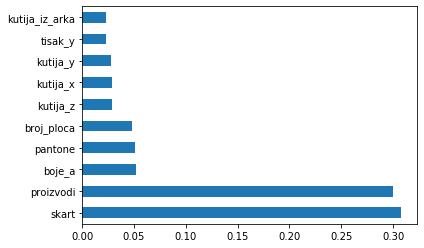

In [15]:
X = testSplits[0]
y = testSplits[2]

model = ExtraTreesClassifier()
model.fit(X, y)

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

### Method No. 3

In [16]:
# https://medium.com/towards-artificial-intelligence/how-to-use-scikit-learn-eli5-library-to-compute-permutation-importance-9af131ece387
import eli5
from eli5.sklearn import PermutationImportance

In [17]:
perm = PermutationImportance(model, random_state = 1).fit(testSplits[0], testSplits[2])
eli5.show_weights(perm, feature_names = testSplits[0].columns.tolist())

Weight,Feature
0.4955 ± 0.0368,proizvodi
0.4233 ± 0.0092,skart
0.0611 ± 0.0131,pantone
0.0571 ± 0.0041,boje_a
0.0341 ± 0.0094,broj_ploca
0.0081 ± 0.0023,tisak_y
0.0074 ± 0.0012,kutija_y
0.0071 ± 0.0032,kutija_x
0.0068 ± 0.0032,papir_x
0.0059 ± 0.0012,debljina
